# Apply reconstruction and filter to longer acquisition

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import json
import cma

from scipy.optimize import least_squares
from pathlib import Path

from qibocal.protocols.two_qubit_interaction.cryoscope import (
    _fit,
    _plot,
    CryoscopeData,
    CryoscopeType,
)

from cryoscope_scripts import load_cryoscope_data
from IIR import (
    step,
    inverse_model_IIR,
    residuals_inverse_IIR,
    multi_exponential_IIR,
    residuals_multi_exponential,
)

[Qibo 0.2.12|INFO|2024-12-12 18:11:47]: Loading platform dummy
[Qibo 0.2.12|INFO|2024-12-12 18:11:47]: Loading platform dummy


In [2]:
data_path = Path.cwd().parent / "cryo_material" / "long_acquisition" / "data" / "cryoscope-0"
data_json = data_path / "data.json"

with open(data_json, "rb") as file:
    data = json.load(file)

flux_pulse_amplitude = data["\"flux_pulse_amplitude\""]
cryoscope_data = load_cryoscope_data(data_path / "data.npz",0.5)

In [3]:
cryoscope_results = _fit(cryoscope_data)

**Test plot function**

In [4]:
t = np.arange(0,99,1)
start = 10
ideal_signal = step(t, start)

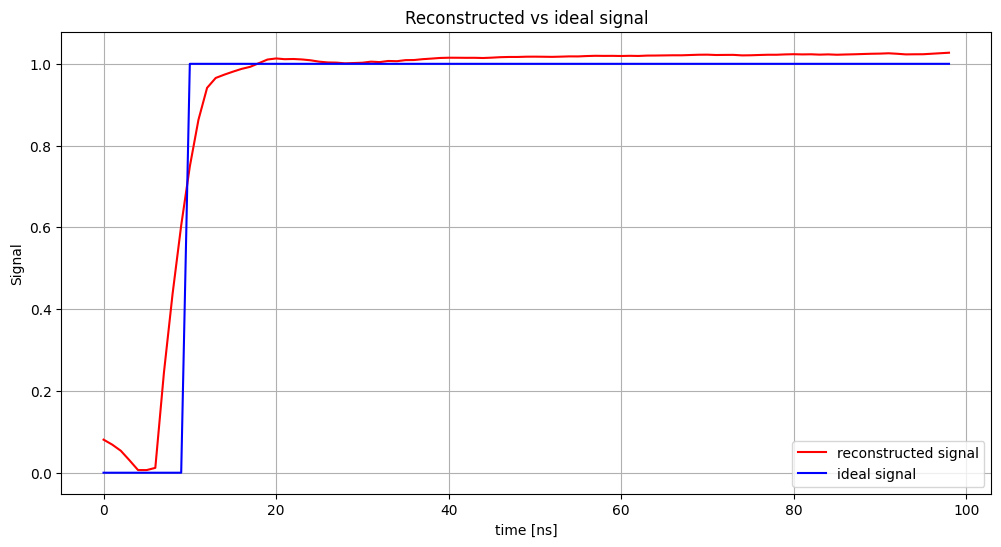

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(cryoscope_results.step_response["D1"], color="red", label="reconstructed signal")
plt.plot(ideal_signal, color="blue", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Reconstructed vs ideal signal")
plt.legend()
plt.grid()
plt.show()

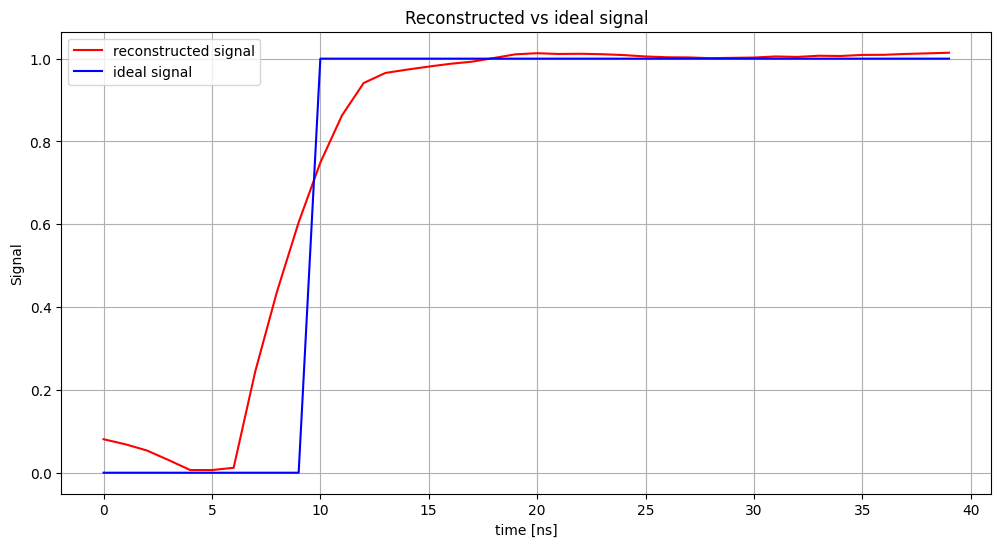

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(
    cryoscope_results.step_response["D1"][:40], color="red", label="reconstructed signal"
)
plt.plot(ideal_signal[:40], color="blue", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Reconstructed vs ideal signal")
plt.legend()
plt.grid()
plt.show()

### IIR Filters 

**Inverse filters iteratively applied**

In [7]:
#single filter application
initial_guess = [1,1,1]
step_response = cryoscope_results.step_response["D1"]
result = least_squares(residuals_inverse_IIR, initial_guess, args=(t, start, step_response))
print(result)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-1.545e-23 -2.230e-21 ...  1.295e-02  1.417e-02]
           x: [ 1.013e+00  1.948e-01 -2.614e-01]
        cost: 0.018716405722484165
         jac: [[ 1.526e-23 -4.073e-21 -5.913e-23]
               [ 2.202e-21 -5.290e-19 -8.533e-21]
               ...
               [-1.000e+00  0.000e+00 -0.000e+00]
               [-1.001e+00  0.000e+00 -0.000e+00]]
        grad: [-1.989e-10  2.120e-08 -1.175e-07]
  optimality: 1.174800214659346e-07
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 13
        njev: 11


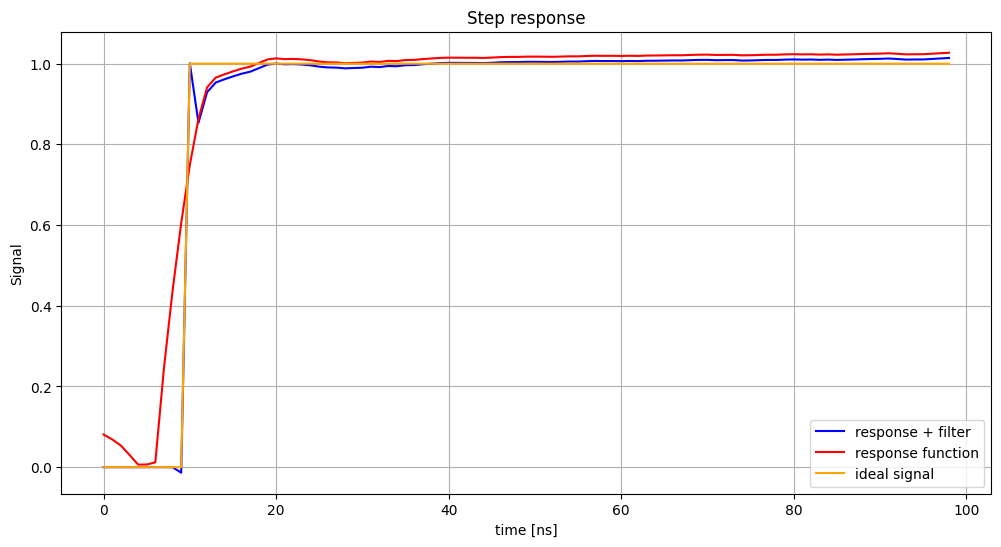

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(t, inverse_model_IIR(result.x, t, start, step_response), color="blue", label="response + filter")
plt.plot(step_response, color="red", label="response function")
plt.plot(t, step(t, start), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

In [9]:
init_guess = [1, 1, 1]
results = []
responses = []

for i in range(5):
    result = least_squares(
        residuals_inverse_IIR, initial_guess, args=(t, start, step_response)
    )
    results.append(result)
    step_response = inverse_model_IIR(result.x, t, start, step_response)
    responses.append(step_response)  # store data at each iteration

/home/elisa/Desktop/Qibo/Qibocal/cryoscope/IIR.py:21: RuntimeWarning: overflow encountered in exp
  return data / (g * (1 + A * np.exp(-(t - start) / tau)))


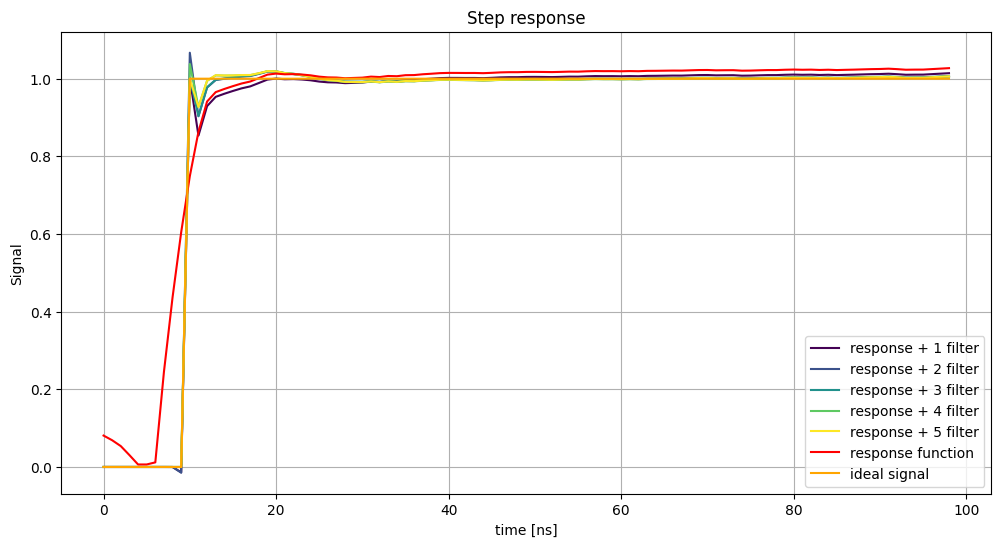

In [10]:
step_response = cryoscope_results.step_response["D1"]
colors = plt.cm.viridis(np.linspace(0, 1, len(responses)))

plt.figure(figsize=(12, 6))

for i, resp in enumerate(responses):
    plt.plot(t, resp, color=colors[i], label=f"response + {i+1} filter")
plt.plot(step_response, color="red", label="response function")
plt.plot(t, step(t, start), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

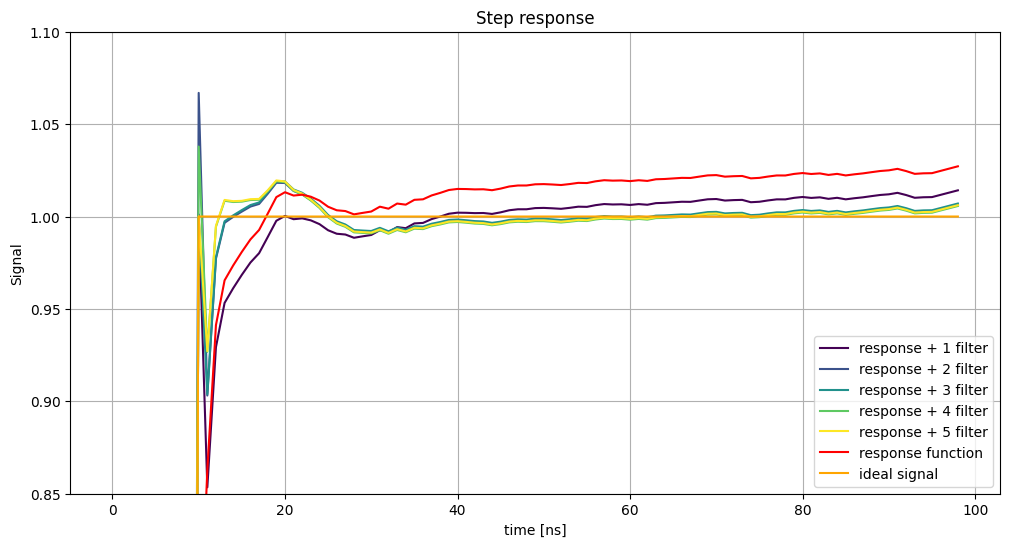

In [11]:
step_response = cryoscope_results.step_response["D1"]
colors = plt.cm.viridis(np.linspace(0, 1, len(responses)))

plt.figure(figsize=(12, 6))

for i, resp in enumerate(responses):
    plt.plot(t, resp, color=colors[i], label=f"response + {i+1} filter")
plt.plot(step_response, color="red", label="response function")
plt.plot(t, step(t, start), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.ylim(0.85, 1.1)
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

**Test filter on monothonically increasing signal**

Test the filter removing the first samples. Test the use of the code from `IIR.py`
The idea in the following is that we should be able to see the signal only from 10 ns on, because we are sending the signal starting at 10 ns, if we see a non-zero signal before is only because the `savitzky-golay` is introducing fictious signal distortions

In [12]:
print(t[10])
print(cryoscope_results.step_response["D1"][10])

10
0.7489311162808548


In [13]:
# single filter application starting optimization from 10ns on

initial_guess = [1, 1, 1]
step_response = cryoscope_results.step_response["D1"]
result = least_squares(
    residuals_inverse_IIR, initial_guess, args=(t[10:], start, step_response[10:])
)
print(result)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-5.680e-03  3.923e-03 ...  8.997e-03  1.021e-02]
           x: [ 1.017e+00  1.932e+00 -2.592e-01]
        cost: 0.002427440988454036
         jac: [[-9.779e-01  0.000e+00 -1.342e+00]
               [-9.873e-01  4.913e-02 -7.077e-01]
               ...
               [-9.923e-01  0.000e+00 -0.000e+00]
               [-9.935e-01  0.000e+00 -0.000e+00]]
        grad: [-5.866e-10 -2.401e-08 -2.223e-08]
  optimality: 2.40122010032812e-08
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 12
        njev: 11


In [14]:
pseudo_t = np.arange(0, 89, 1)
pseudo_step = np.ones_like(pseudo_t)
print(pseudo_step)
print(pseudo_t)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88]


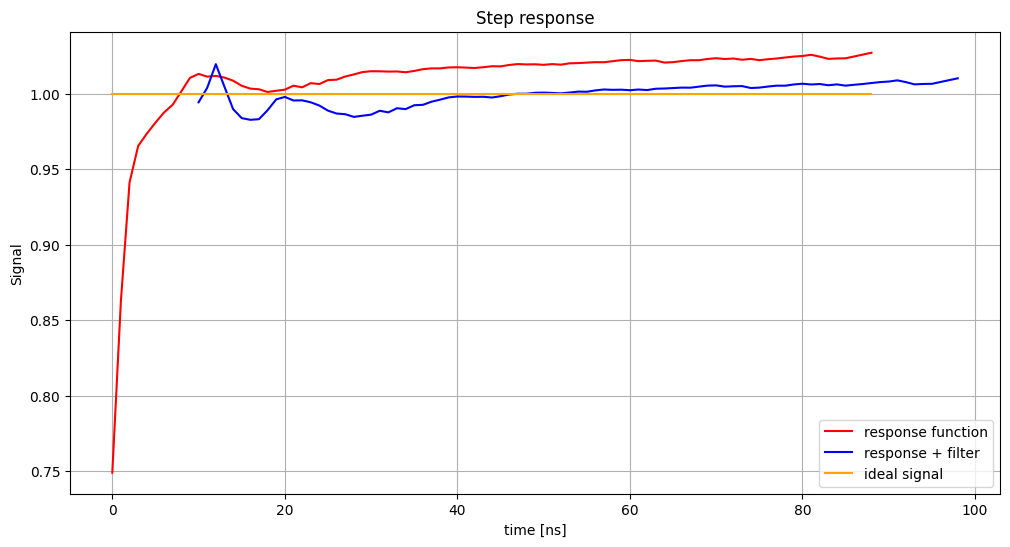

In [15]:
#è traslata ma è corretta, sistemare il codice di conseguenza

plt.figure(figsize=(12, 6))
plt.plot(step_response[10:], color="red", label="response function")
plt.plot(
    t[10:],
    inverse_model_IIR(result.x, t[10:], start, step_response[10:]),
    color="blue",
    label="response + filter",
)

plt.plot(pseudo_t, pseudo_step, color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

**Inverse filter simultaneously optimized**

In [16]:
initial_guess = [1, 1, 1, 1, 1, 1, 1, 1, 1]
step_response = cryoscope_results.step_response["D1"]
result = least_squares(
    residuals_multi_exponential, initial_guess, args=(t, start, step_response)
)
print(result)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-1.981e-92 -3.435e-83 ...  9.230e-04  2.037e-03]
           x: [ 1.013e+00  1.463e+00 -2.571e-01  1.010e+00  3.908e+01
               -3.299e-02  1.006e+00  4.820e-02  1.346e-02]
        cost: 0.0005085941716948513
         jac: [[ 1.956e-92 -9.296e-92 ... -8.530e-89  1.472e-90]
               [ 3.392e-83 -1.457e-82 ... -1.331e-79  2.552e-81]
               ...
               [-9.884e-01  0.000e+00 ...  0.000e+00  0.000e+00]
               [-9.895e-01  0.000e+00 ...  0.000e+00  0.000e+00]]
        grad: [-4.865e-06  1.235e-08 -1.377e-07 -4.877e-06  2.659e-10
               -2.004e-06 -4.899e-06  3.469e-12 -5.462e-08]
  optimality: 4.899020094990391e-06
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
                0.000e+00  0.000e+00  0.000e+00  0.000e+00]
        nfev: 82
        njev: 55


/home/elisa/Desktop/Qibo/Qibocal/cryoscope/IIR.py:27: RuntimeWarning: overflow encountered in multiply
  (g_1 * (1 + A_1 * np.exp(-(t - start) / tau_1)))
/home/elisa/Desktop/Qibo/Qibocal/cryoscope/IIR.py:27: RuntimeWarning: overflow encountered in exp
  (g_1 * (1 + A_1 * np.exp(-(t - start) / tau_1)))
/home/elisa/Desktop/Qibo/Qibocal/cryoscope/IIR.py:28: RuntimeWarning: overflow encountered in exp
  * (g_2 * (1 + A_2 * np.exp(-(t - start) / tau_2)))
/home/elisa/Desktop/Qibo/Qibocal/cryoscope/IIR.py:29: RuntimeWarning: overflow encountered in exp
  * (g_3 * (1 + A_3 * np.exp(-(t - start) / tau_3)))


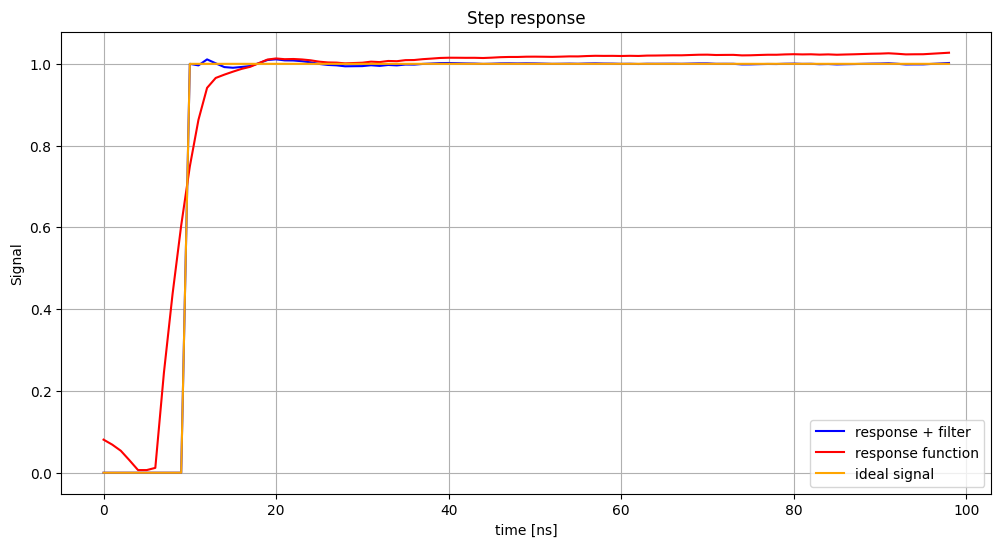

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(
    t,
    multi_exponential_IIR(result.x, t, start, step_response),
    color="blue",
    label="response + filter",
)
plt.plot(step_response, color="red", label="response function")
plt.plot(t, step(t, start), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

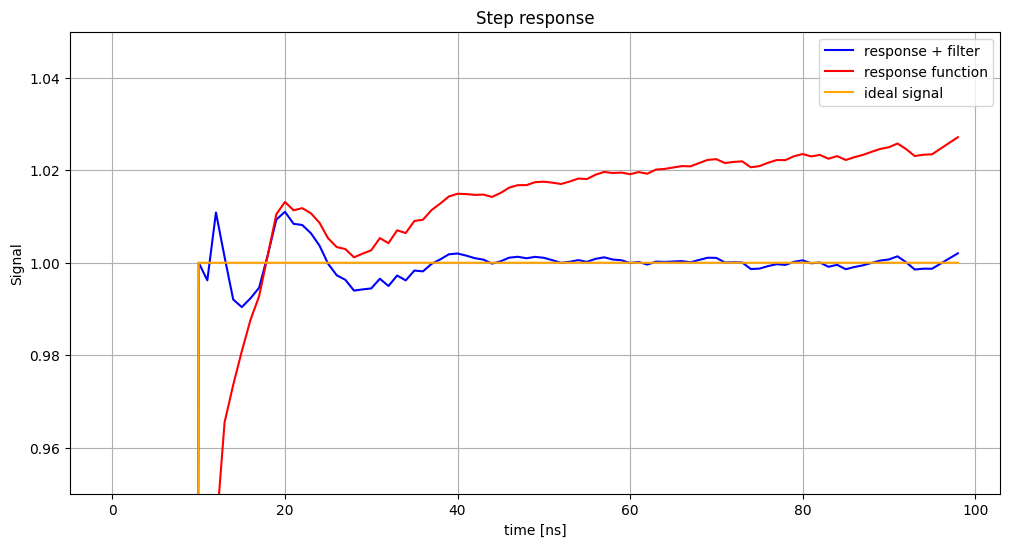

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(
    t,
    multi_exponential_IIR(result.x, t, start, step_response),
    color="blue",
    label="response + filter",
)
plt.plot(step_response, color="red", label="response function")
plt.plot(t, step(t, start), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.ylim(0.95, 1.05)
plt.title("Step response")
plt.legend()
plt.grid()

### Applicazione FIR

From here on I assume for simplicity that the signal starts at 10 ns. In the following I plot how a consider the ideal response, the filtered response and the reconstructed response (this last one is actually not relevant) for the computation of the FIR filter coefficients

In [21]:
reconstructed_response = cryoscope_results.step_response["D1"][10:]
t = np.arange(0,len(reconstructed_response),1)
start = 0

filtered_response = multi_exponential_IIR(result.x, t, start, reconstructed_response)

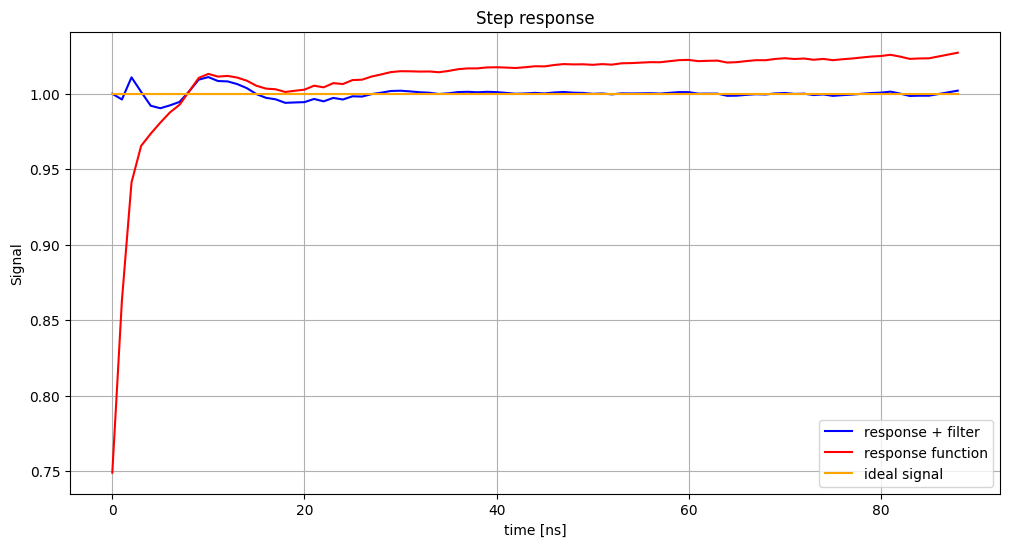

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(
    t,
    filtered_response,
    color="blue",
    label="response + filter",
)
plt.plot(reconstructed_response, color="red", label="response function")
plt.plot(t, step(t, 0), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

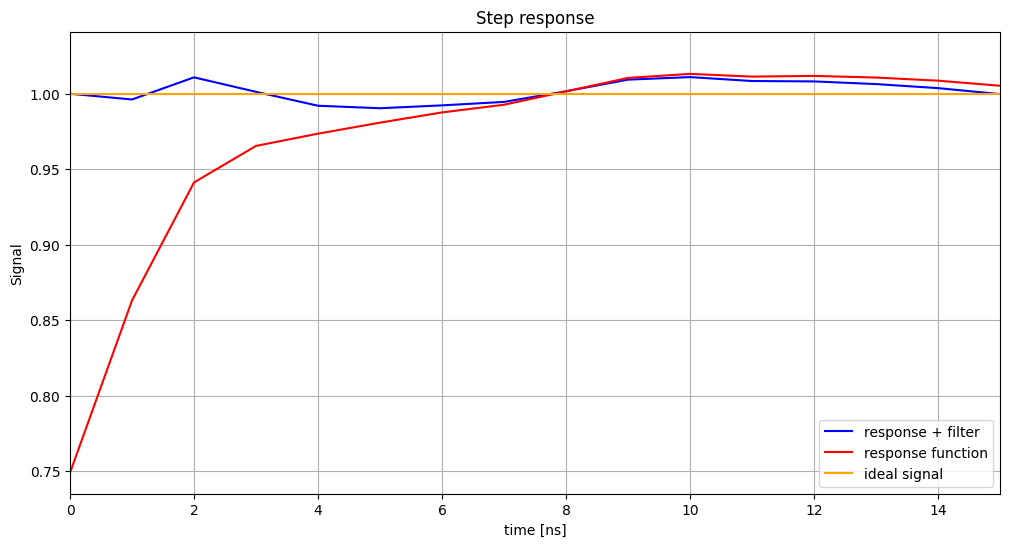

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(
    t,
    filtered_response,
    color="blue",
    label="response + filter",
)
plt.plot(reconstructed_response, color="red", label="response function")
plt.plot(t, step(t, 0), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.xlim(0,15)
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

As first test for the search for the FIR filters I want to look for coefficients for the whole signal. Then, considering the results I get I will decide how to proceed. In the following I line out some possibilities:
* Keep coefficients for the complete signal length (we expect them to go to 0)
* Keep a parameter for more than 2 coefficients
* Reduce the FIR parameters search to the first (eg. 15/20 ns) and then apply the FIR setting higher coefficients to 0

TODO: look at the `np.convolve` function works

In [25]:
def FIR_filter(x, coefficients):
    """Applies the FIR filter to the input signal x using coefficients b."""

    y = np.convolve(x, coefficients, mode="full") #check mode and evaluate what is better
    return y


def cost_function(params, signal, t, start):
    coefficients = params[:6] #I set the first 6 parameters as 6 coefficients    

    for i in range(6, len(signal)):
        coefficients = np.append(coefficients, [params[i], params[i]])
    
    y=FIR_filter(signal,coefficients)

    return np.sum((y - step(t, start))**2)
    #consider using mse instead of this

In [ ]:
initial_guess = np.ones_like(len(reconstructed_response))
sigma = 0.25

#decidere quale cma utilizzare
result = cma.

In [ ]:
# test code

import numpy as np
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt


# Define the FIR filter convolution function
def fir_filter(x, coefficients):
    """Applies FIR filtering via convolution."""
    return np.convolve(x, coefficients, mode="same")


# Define the cost function for optimization
def cost_function(params, input_signal, ideal_response):
    """Calculates the error between the filter's output and the ideal response."""
    # Extract the first 8 coefficients directly
    coefficients = params[:8]

    # Use the remaining parameters to generate pairs for the rest of the coefficients
    for i in range(8, 40):
        coefficients = np.append(coefficients, [params[i], params[i]])

    # Compute the filter's output
    output_signal = fir_filter(input_signal, coefficients)

    # Compute the mean squared error (MSE) against the ideal response
    mse = np.mean((output_signal - ideal_response) ** 2)
    return mse


# Generate synthetic data: step function (ideal response)
signal_length = 100
step_signal = np.zeros(signal_length)
step_signal[signal_length // 2 :] = 1  # Step starts halfway

# Generate a synthetic input signal (e.g., noisy step function)
np.random.seed(42)  # For reproducibility
input_signal = step_signal + 0.1 * np.random.normal(size=signal_length)

# Define CMA-ES optimization parameters (40 parameters)
param_bounds = [(-1, 1)] * 40  # Assume filter coefficients range between -1 and 1

# Run optimization
result = differential_evolution(
    cost_function,
    bounds=param_bounds,
    args=(input_signal, step_signal),
    strategy="best1bin",
    maxiter=100,
    popsize=15,
    tol=1e-6,
    seed=42,
)

# Extract optimized parameters
optimized_params = result.x

# Reconstruct the full set of coefficients
optimized_coefficients = optimized_params[:8]
for i in range(8, 40):
    optimized_coefficients = np.append(
        optimized_coefficients, [optimized_params[i], optimized_params[i]]
    )

# Apply the FIR filter with optimized coefficients
filtered_signal = fir_filter(input_signal, optimized_coefficients)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(input_signal, label="Input Signal", linestyle="dashed")
plt.plot(step_signal, label="Ideal Step Response", linestyle="dotted")
plt.plot(filtered_signal, label="Filtered Signal", linewidth=2)
plt.legend()
plt.title("FIR Filter Optimization with CMA-ES")
plt.xlabel("Sample Index")
plt.ylabel("Signal Amplitude")
plt.grid()
plt.show()

TO DO LIST:

- [] Provare a usare savgol con opzione nearest 
- [] Vedere se conviene variare la WL del savgol 
- [] Provare a cambiare la normalizzazione del savgol
- [] Salvare in maniera sistematica i parametri dei filtri per poterli confrontare (considerato che il modello di filtro da applicare è sempre lo stesso :) )
- [] Provare a creare i filtri a partire da WL diverse e proprietà diverse del savgol, ricavre i filtri, applicare le correzioni ai qubit e vedere con i filtri ricavati dalle diverse ricostruzioni quanto migliora la fidelity dei gate 

### Old tests 

Old tests that I want to keep only to show how different the results were if I considered the ideal signal to start at 0 ns instead of 10 ns and optimized the IIR parameters on that.
Note: the plot has been made starting from 0 only to see how well the filter performed also out of the "training range"

In [11]:
initial_guess = [1,1,1]
step_response = cryoscope_results.step_response["D1"][6:]
result = least_squares(residuals_inverse_IIR, initial_guess, args=(t[6:], start, step_response))
print(result)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-9.882e-01 -7.557e-01 ...  2.291e-02  2.414e-02]
           x: [ 1.003e+00  1.384e-01  9.210e-01]
        cost: 1.0668605639378017
         jac: [[-1.180e-02  0.000e+00  0.000e+00]
               [-2.436e-01  0.000e+00  0.000e+00]
               ...
               [-1.020e+00  0.000e+00  0.000e+00]
               [-1.021e+00  0.000e+00  0.000e+00]]
        grad: [-3.589e-06  0.000e+00  0.000e+00]
  optimality: 3.589410618072648e-06
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 15
        njev: 4


In [12]:
step_response = cryoscope_results.step_response["D1"]

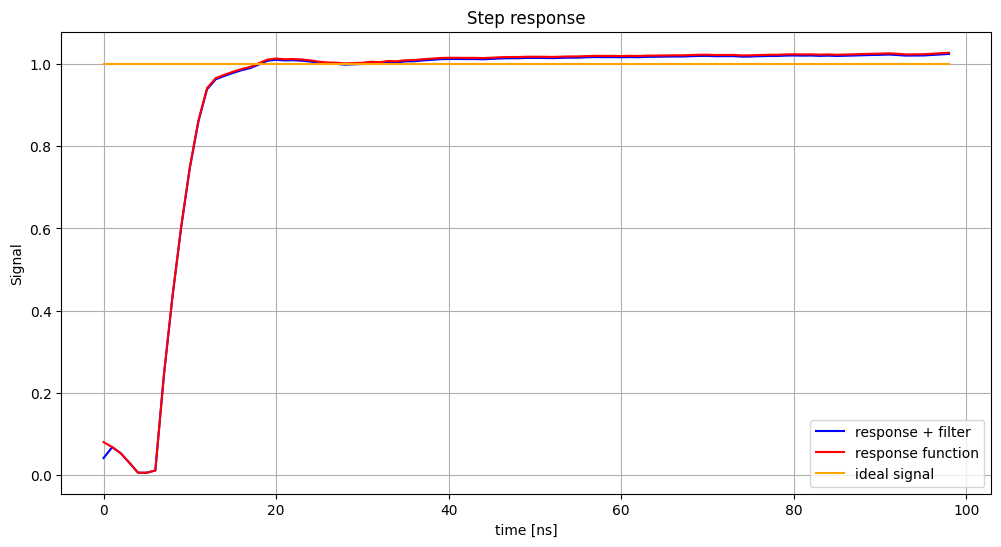

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(t, inverse_model_IIR(result.x, t, start, step_response), color="blue", label="response + filter")
plt.plot(step_response, color="red", label="response function")
plt.plot(t, step(t, start), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

Test the same filter but using local version of the code

In [14]:
def step(t):
    return np.ones_like(t)

def model(params, t, data):
    g, tau, A = params
    return data / (g * (1 + A * np.exp(-t / tau)))  # exp(-t/tau)

def residuals(params, t, data):
    return model(params, t, data) - step(t)

In [15]:
initial_guess = [1, 1, 1]
step_response = cryoscope_results.step_response["D1"][6:]
result = least_squares(
    residuals, initial_guess, args=(t[6:], step_response)
)
print(result)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-9.882e-01 -7.557e-01 ...  2.291e-02  2.414e-02]
           x: [ 1.003e+00  1.384e-01  9.210e-01]
        cost: 1.0668605639378017
         jac: [[-1.180e-02  0.000e+00  0.000e+00]
               [-2.436e-01  0.000e+00  0.000e+00]
               ...
               [-1.020e+00  0.000e+00  0.000e+00]
               [-1.021e+00  0.000e+00  0.000e+00]]
        grad: [-3.589e-06  0.000e+00  0.000e+00]
  optimality: 3.589410618072648e-06
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 15
        njev: 4


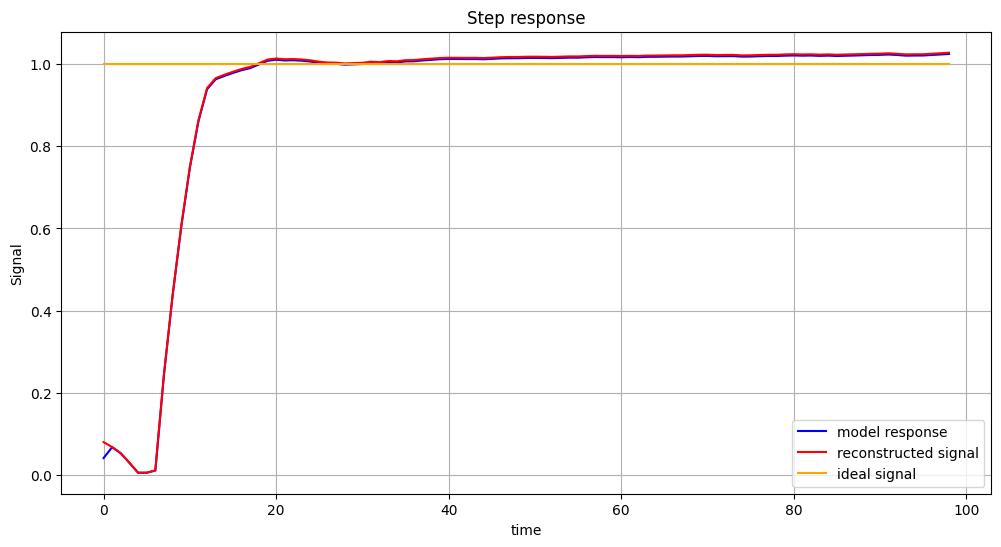

In [17]:
step_response = cryoscope_results.step_response["D1"]

plt.figure(figsize=(12, 6))
plt.plot(t, model(result.x, t, step_response), color="blue", label="model response")
plt.plot(step_response, color="red", label="reconstructed signal")
plt.plot(t, step(t), color="orange", label="ideal signal")
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

Testing starting from 3 instead of 6 where indeed start the exponential

In [18]:
initial_guess = [1, 1, 1]
step_response = cryoscope_results.step_response["D1"][3:]
result = least_squares(
    residuals_inverse_IIR, initial_guess, args=(t[3:], start, step_response)
)
print(result)

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-9.695e-01 -9.936e-01 ...  2.338e-02  2.461e-02]
           x: [ 1.002e+00  4.251e-02  8.399e-01]
        cost: 2.524024055671301
         jac: [[-3.039e-02  0.000e+00  0.000e+00]
               [-6.425e-03  0.000e+00  0.000e+00]
               ...
               [-1.021e+00  0.000e+00  0.000e+00]
               [-1.022e+00  0.000e+00  0.000e+00]]
        grad: [ 1.565e-08  0.000e+00  0.000e+00]
  optimality: 1.5650064695560406e-08
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 18
        njev: 4


In [21]:
step_response = cryoscope_results.step_response["D1"]

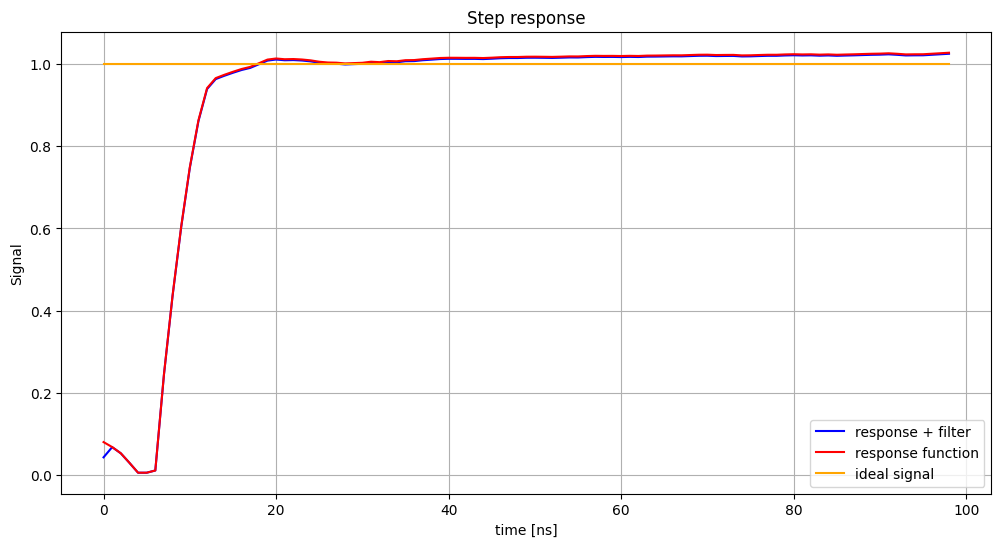

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(
    t,
    inverse_model_IIR(result.x, t, start, step_response),
    color="blue",
    label="response + filter",
)
plt.plot(step_response, color="red", label="response function")
plt.plot(t, step(t), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()